In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def merge_csvs_and_remove_duplicates(files):
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(file))
    df = pd.concat(df_list, ignore_index=True)
    df = df.drop_duplicates(subset=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], keep='first')
    df = df.sort_values(by=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], ascending=[True, True, True, True, True, True, True, True, True])
    df.drop_duplicates(inplace=True)
    return df

files = ['diabetes (1).csv', 'diabetes (2).csv', 'diabetes (3).csv', 'diabetes (4).csv', 'diabetes (5).csv', 'diabetes (6).csv', 'diabetes (7).csv', 'diabetes (8).csv']
df = merge_csvs_and_remove_duplicates(files)
df.to_csv('diabetes.csv', index=False)


Форма датасета: (778, 9)

Типы данных:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Пропуски:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Первые строки:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
537            0       57             60              0        0  21.7   
596            0       67             76              0        0  45.3   
589            0       73              0              0        0  21.1   
466            0 

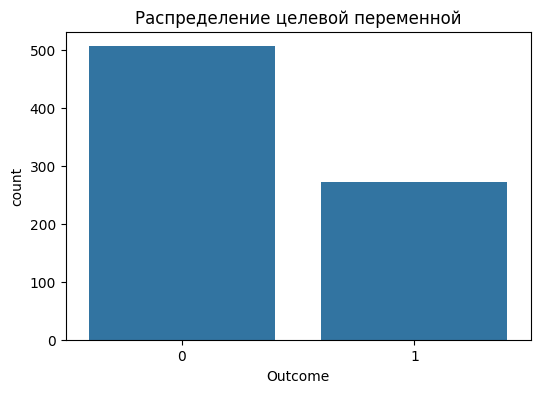

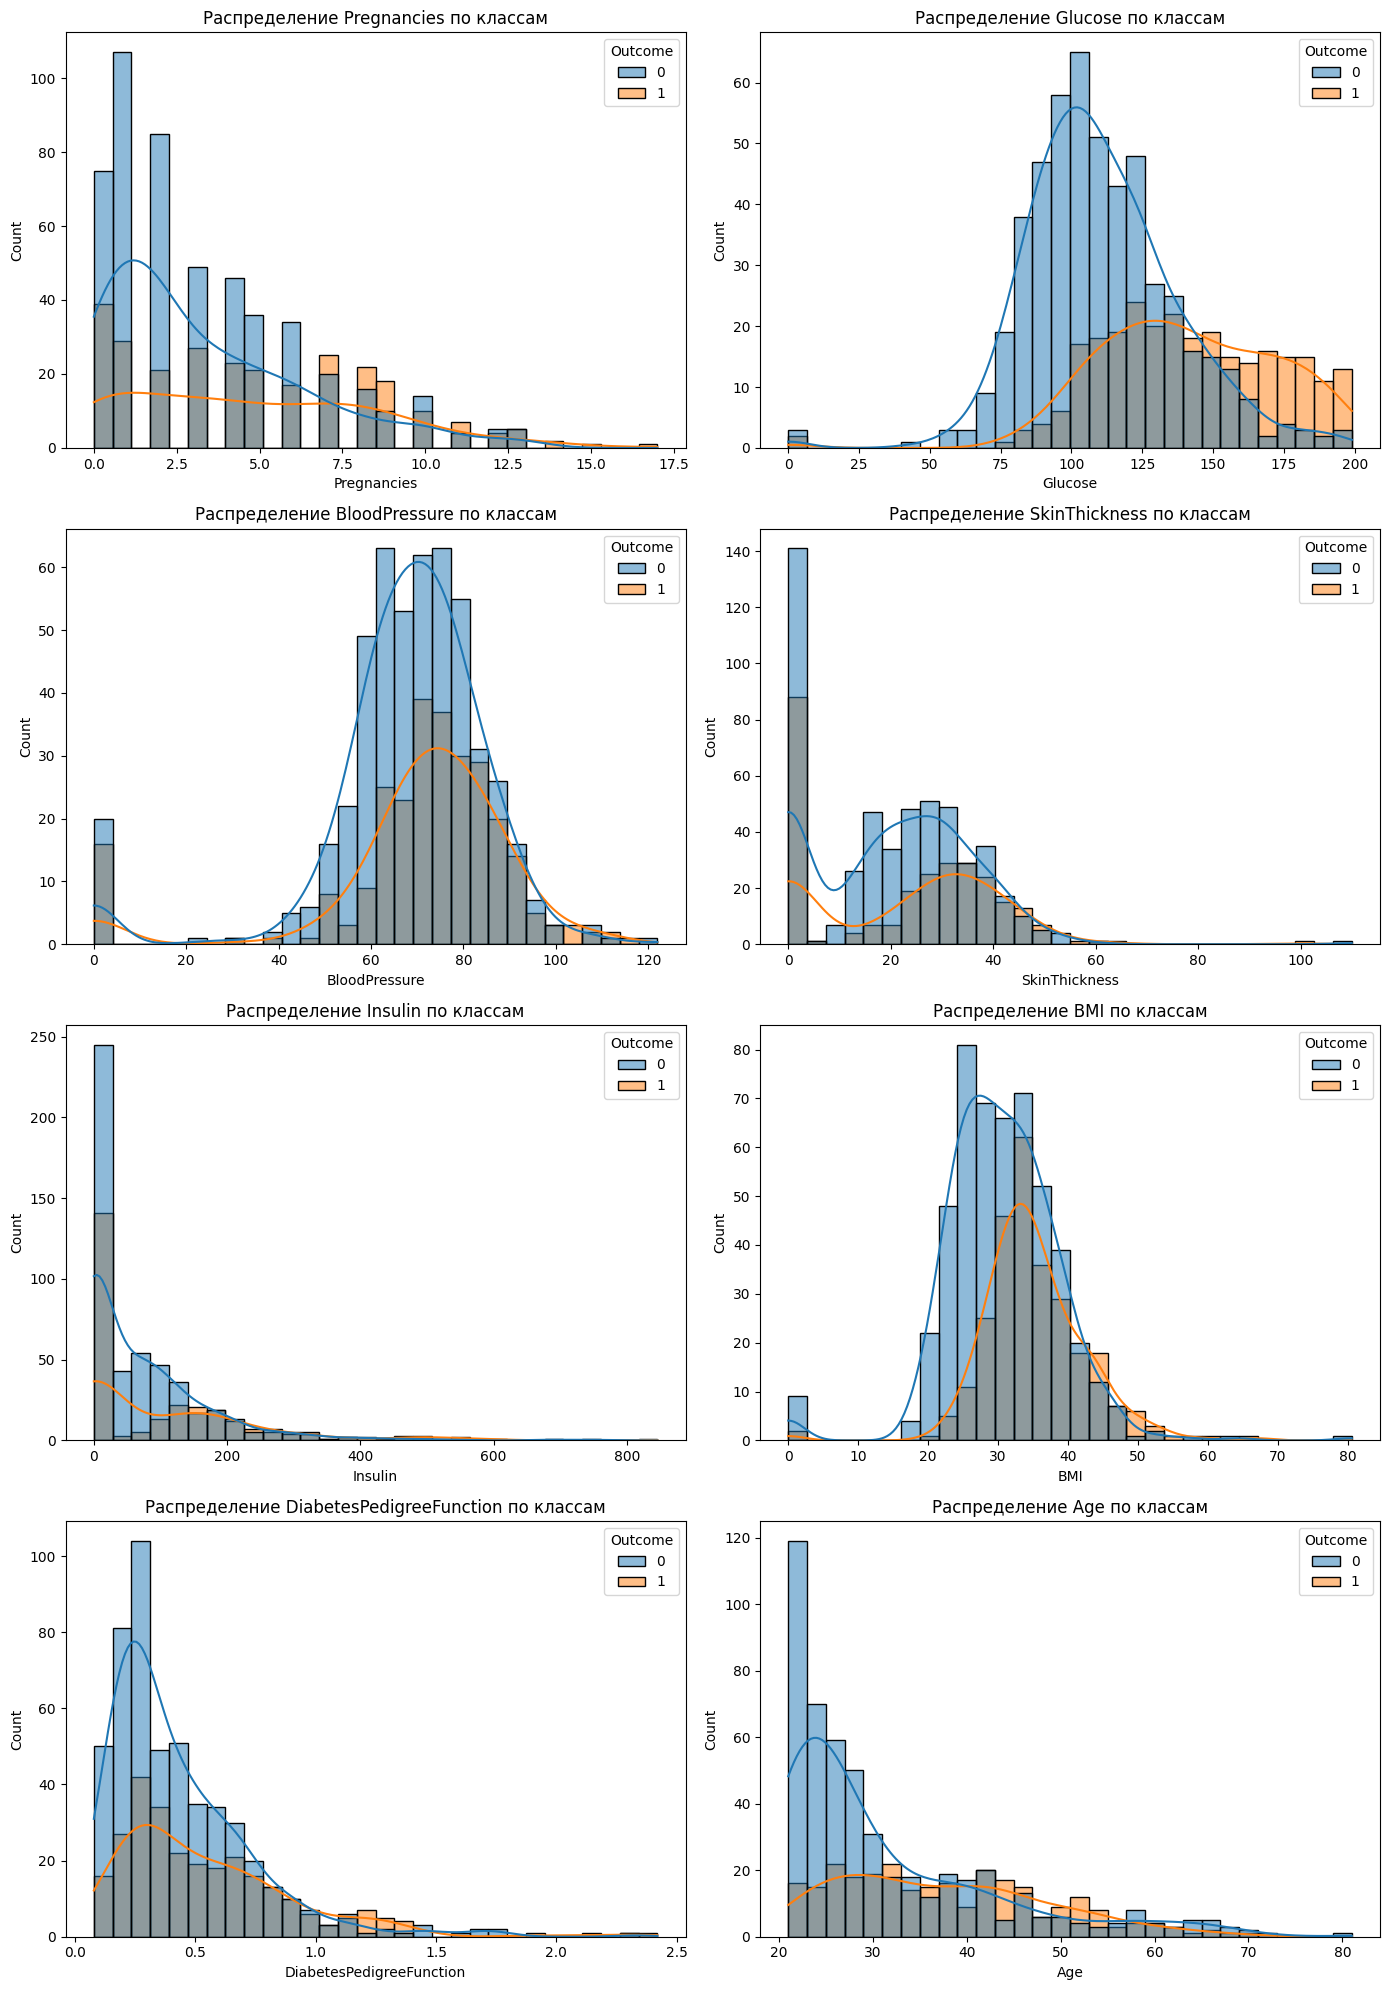

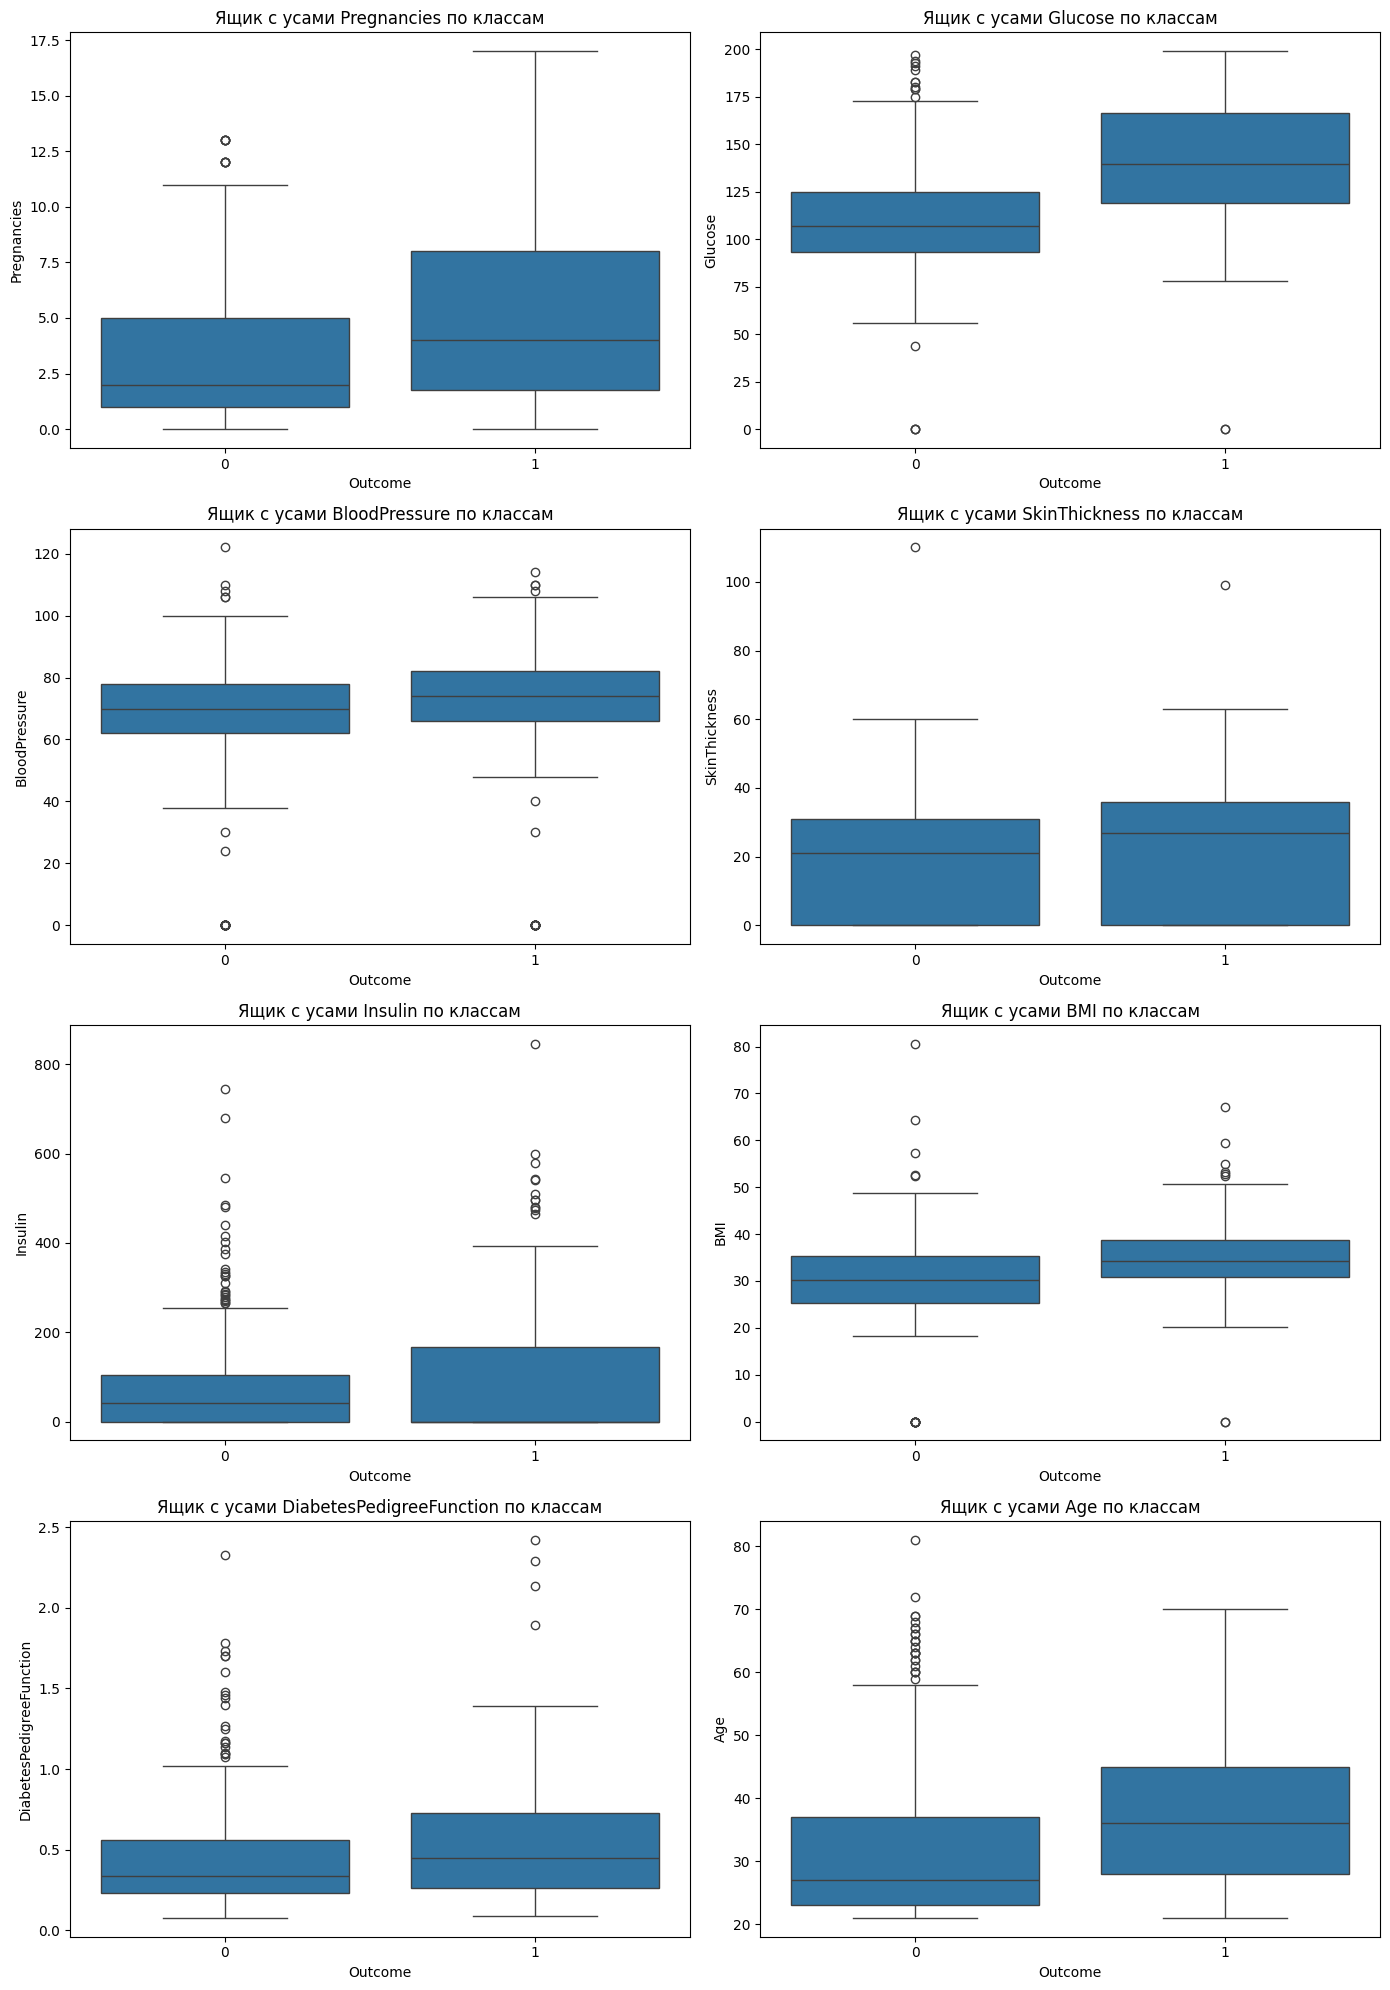

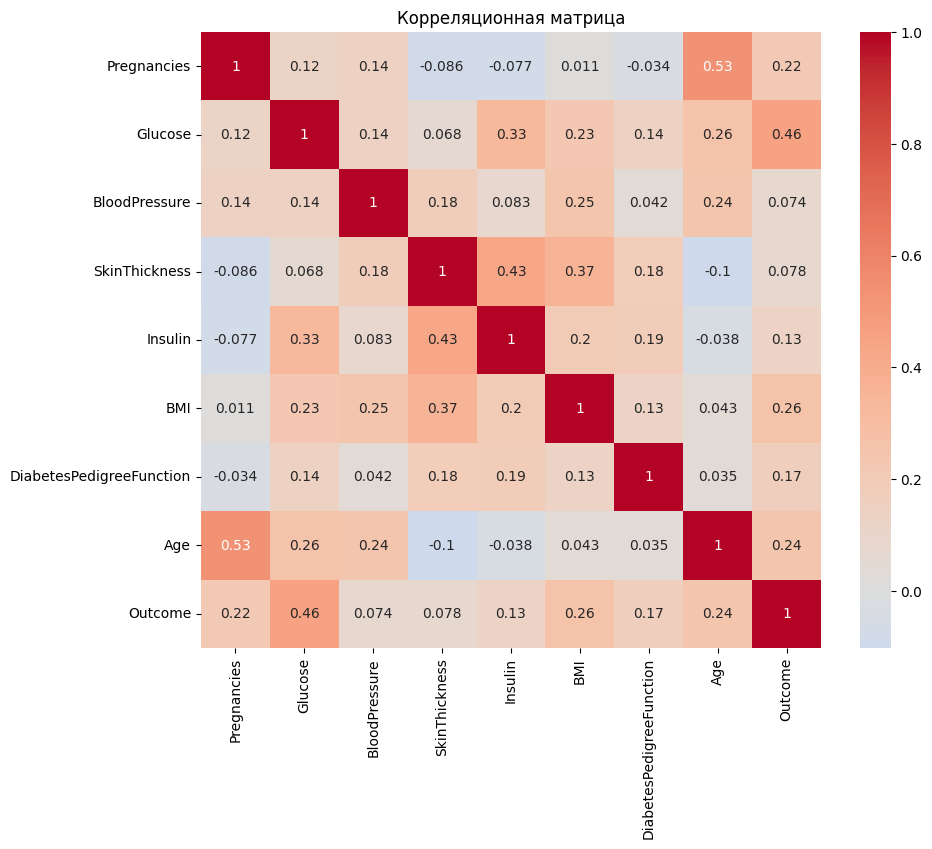


Описательные статистики по классам:
Outcome                     0           1
Pregnancies count  506.000000  272.000000
            mean     3.278656    4.830882
            std      3.008802    3.733868
            min      0.000000    0.000000
            25%      1.000000    1.750000
...                       ...         ...
Age         min     21.000000   21.000000
            25%     23.000000   28.000000
            50%     27.000000   36.000000
            75%     37.000000   45.000000
            max     81.000000   70.000000

[64 rows x 2 columns]

Дисперсия признаков:
DiabetesPedigreeFunction        0.109019
Pregnancies                    11.294937
BMI                            67.497511
Age                           138.981079
SkinThickness                 266.659567
BloodPressure                 379.146121
Glucose                      1023.413281
Insulin                     13251.118110
dtype: float64


In [3]:
print("Форма датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)
print("\nПропуски:")
print(df.isnull().sum())
print("\nПервые строки:")
print(df.head())

# Проверка на нулевые/некорректные значения
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
print("\nНулевые значения в медицински значимых столбцах:")
for col in zero_cols:
    print(f"{col}: {(df[col] == 0).sum()}")

# Анализ целевой переменной
print("\nБаланс классов (Outcome):")
print(df['Outcome'].value_counts())
print(df['Outcome'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Outcome')
plt.title('Распределение целевой переменной')
plt.show()

# Распределения числовых признаков по классам
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(data=df, x=col, hue='Outcome', kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Распределение {col} по классам')
plt.tight_layout()
plt.show()

# Ящик с усами для выявления выбросов
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(data=df, x='Outcome', y=col, ax=axes[i])
    axes[i].set_title(f'Ящик с усами {col} по классам')
plt.tight_layout()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

# Статистики по классам
print("\nОписательные статистики по классам:")
print(df.groupby('Outcome')[features].describe().T)

# Проверка на константные признаки
print("\nДисперсия признаков:")
print(df[features].var().sort_values())

In [4]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Замена нулевых значений
zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for col in zero_as_missing:
    df[col] = df[col].replace(0, np.nan)

# Удаление строк, где Glucose — NaN (критичный признак, без него диагноз невозможен)
df = df.dropna(subset=['Glucose'])

# 3. Импутация оставшихся пропусков
imputer = KNNImputer(n_neighbors=5)
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df[feature_cols] = imputer.fit_transform(df[feature_cols])

# Удаление явных выбросов по медицинским критериям
# Диастолическое давление < 20 или > 130 — недостоверно
df = df[(df['BloodPressure'] >= 20) & (df['BloodPressure'] <= 130)]
# BMI < 12 или > 70 — физиологически маловероятно
df = df[(df['BMI'] >= 12) & (df['BMI'] <= 70)]
# SkinThickness > 99 — верхняя граница измерений в датасете
df = df[df['SkinThickness'] <= 99]
# Insulin > 800 — клинически экстремальное значение, вероятно ошибка
df = df[df['Insulin'] <= 800]

# Масштабирование признаков
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
print(df['Age'])

# Финальная проверка
print("Форма после предобработки:", df.shape)
print("Пропуски:", df.isnull().sum().sum())
print("Дубликаты:", df.duplicated().sum())

537    2.858507
596    1.074698
589   -0.709111
466   -0.963941
290   -1.048884
         ...   
691    0.904812
298    1.074698
455    0.395152
88     0.819868
159    1.159642
Name: Age, Length: 770, dtype: float64
Форма после предобработки: (770, 9)
Пропуски: 0
Дубликаты: 0


In [5]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Конструирование признаков
# BMI категории (по ВОЗ)
X['BMI_Category'] = pd.cut(X['BMI'],
                           bins=[-np.inf, 18.5, 25, 30, np.inf],
                           labels=[0, 1, 2, 3])  # 0: недостаток, 1: норма, 2: избыток, 3: ожирение

# Возрастные группы
X['Age_Group'] = pd.cut(X['Age'],
                        bins=[-np.inf, 30, 40, 50, np.inf],
                        labels=[0, 1, 2, 3])

# Глюкоза по медицинским порогам (норма < 140)
X['Glucose_High'] = (X['Glucose'] >= 140).astype(int)

# Комбинированные признаки
X['Glucose_BMI'] = X['Glucose'] * X['BMI']
X['Insulin_Glucose_Ratio'] = X['Insulin'] / (X['Glucose'] + 1e-6)  # избегаем деления на ноль

# Число беременностей с учётом возраста
X['Pregnancies_per_Age'] = X['Pregnancies'] / (X['Age'] + 1e-6)

# Преобразуем категориальные признаки в числовые
X['BMI_Category'] = X['BMI_Category'].astype(int)
X['Age_Group'] = X['Age_Group'].astype(int)


In [6]:
print(X)
print(y)

     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
537    -1.137714 -2.130702      -1.009909      -0.183454 -0.710693 -1.534723   
596    -1.137714 -1.801712       0.293008      -0.054214 -0.710693  1.809488   
589    -1.137714 -1.604318      -1.058769      -0.614253 -0.710693 -1.619745   
466    -1.137714 -1.571419      -1.661368      -2.078972 -0.389017 -0.670329   
290    -1.137714 -1.439823       1.270197      -0.032674 -0.353275  0.619176   
..           ...       ...            ...            ...       ...       ...   
691     2.721492  1.192098       3.387438       0.764306 -0.710693  1.384377   
298     3.018354 -0.716045       0.455873      -0.463473  0.933430  0.576665   
455     3.018354  1.751381      -0.847045       0.075026 -0.710693  0.151553   
88      3.315216  0.468320      -0.195586       0.290426  0.272206  0.647517   
159     3.908939  1.356593      -0.032721       1.259726  0.307948  1.185991   

     DiabetesPedigreeFunction       Age

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Определение архитектуры нейронной сети
class DiabetesNet(nn.Module):
    def __init__(self, input_size):
        super(DiabetesNet, self).__init__()
        # Полносвязные слои
        self.fc1 = nn.Linear(input_size, 64)  # Вход -> 64 нейрона
        self.relu1 = nn.ReLU()                # Активация ReLU
        self.dropout1 = nn.Dropout(0.3)       # Регуляризация
        
        self.fc2 = nn.Linear(64, 32)          # 64 -> 32
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(32, 1)           # 32 -> 1 (бинарный выход)
        self.sigmoid = nn.Sigmoid()           # Функция активации для вероятности

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

X_np = X.values.astype(np.float32)  # Преобразование в numpy array
y_np = y.values.astype(np.float32)  # Преобразование в numpy array

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Создание модели
input_size = X_train.shape[1]  # количество признаков
model = DiabetesNet(input_size)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Обучение модели
epochs = 10000
for epoch in range(epochs):
    model.train()
    
    # Прямой проход
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Обратный проход
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')




Epoch [100/10000], Loss: 0.6796
Epoch [200/10000], Loss: 0.6389
Epoch [300/10000], Loss: 0.5927
Epoch [400/10000], Loss: 0.5716
Epoch [500/10000], Loss: 0.5598
Epoch [600/10000], Loss: 0.5551
Epoch [700/10000], Loss: 0.5083
Epoch [800/10000], Loss: 0.5238
Epoch [900/10000], Loss: 0.5044
Epoch [1000/10000], Loss: 0.4997
Epoch [1100/10000], Loss: 0.5083
Epoch [1200/10000], Loss: 0.4963
Epoch [1300/10000], Loss: 0.4829
Epoch [1400/10000], Loss: 0.4696
Epoch [1500/10000], Loss: 0.4653
Epoch [1600/10000], Loss: 0.4619
Epoch [1700/10000], Loss: 0.4637
Epoch [1800/10000], Loss: 0.4535
Epoch [1900/10000], Loss: 0.4566
Epoch [2000/10000], Loss: 0.4665
Epoch [2100/10000], Loss: 0.4645
Epoch [2200/10000], Loss: 0.4644
Epoch [2300/10000], Loss: 0.4377
Epoch [2400/10000], Loss: 0.4373
Epoch [2500/10000], Loss: 0.4561
Epoch [2600/10000], Loss: 0.4501
Epoch [2700/10000], Loss: 0.4418
Epoch [2800/10000], Loss: 0.4398
Epoch [2900/10000], Loss: 0.4392
Epoch [3000/10000], Loss: 0.4526
Epoch [3100/10000],

Test Accuracy: 0.8117

Дополнительные метрики:
Precision (точность положительного класса): 0.7027
Recall (полнота / чувствительность):      0.5909
F1-score:                                 0.6420
ROC-AUC:                                  0.8806


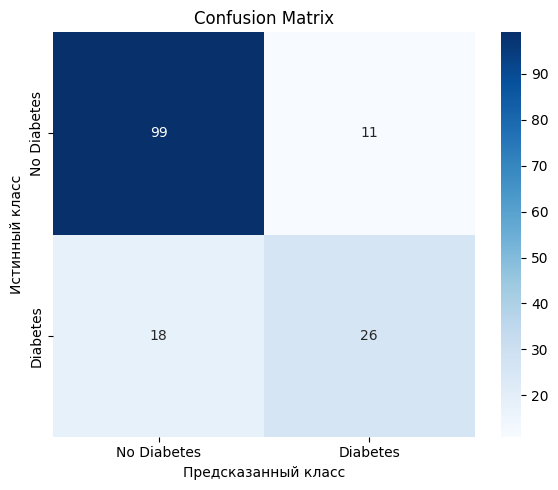

In [27]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted = (test_outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Test Accuracy: {accuracy.item():.4f}')

    # Преобразуем тензоры в numpy
    y_true = y_test_tensor.numpy().flatten()
    y_pred = predicted.numpy().flatten()

    # Дополнительные метрики
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, test_outputs.numpy().flatten())

    print(f'\nДополнительные метрики:')
    print(f'Precision (точность положительного класса): {precision:.4f}')
    print(f'Recall (полнота / чувствительность):      {recall:.4f}')
    print(f'F1-score:                                 {f1:.4f}')
    print(f'ROC-AUC:                                  {roc_auc:.4f}')

    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.show()